In [1]:
# Install libraries (this may take 1–3 minutes)
!pip -q install --upgrade pip
!pip -q install "transformers>=4.44.0" accelerate datasets pillow qwen-vl-utils

import torch, os, sys, platform
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device being used:", device)

# Create an outputs folder where we’ll save CSV/Markdown results
os.makedirs("/content/outputs", exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.3 MB/s eta 0:00:00
PyTorch: 2.8.0+cu126
CUDA available: True
Device being used: cuda


In [2]:
from datasets import load_dataset
from PIL import Image
import re, os, json

# 1) Load the dataset from Hugging Face
ds = load_dataset("elischwartz/synthetic-watch-faces-dataset")
print(ds)  # you'll see train/val/test splits

# 2) Convert label "HH:MM" to normalized hour/minute
def label_to_hm(label):
    # label is a string like "03:45" or "3:5"
    hh, mm = map(int, label.split(":"))
    hh = ((hh - 1) % 12) + 1  # force to 1..12
    mm = mm % 60
    return hh, mm

# 3) Extract "HH:MM" from model text output (we will force the model to answer only a time)
_time_pat = re.compile(r'(\d{1,2})\s*[:：]\s*(\d{1,2})')

def extract_time(text):
    if not isinstance(text, str):
        return None
    m = _time_pat.search(text)
    if not m:
        return None
    hh = int(m.group(1)); mm = int(m.group(2))
    hh = ((hh - 1) % 12) + 1
    mm = mm % 60
    return f"{hh:02d}:{mm:02d}"

# 4) Simple metrics (exact match, hour-only, minute-only)
def evaluate_predictions(rows):
    """
    rows = list of dicts: {'gold': 'HH:MM', 'pred': 'HH:MM' or None}
    Returns dict with summary metrics.
    """
    n = len(rows)
    exact = hour_ok = minute_ok = pred_any = 0
    for r in rows:
        g = r['gold']
        p = r['pred']
        if p is not None:
            pred_any += 1
            gh, gm = map(int, g.split(":"))
            ph, pm = map(int, p.split(":"))
            if gh == ph and gm == pm: exact += 1
            if gh == ph: hour_ok += 1
            if gm == pm: minute_ok += 1
    return {
        "n_samples": n,
        "predicted_any": pred_any,
        "exact_time_acc": exact / n,
        "hour_only_acc": hour_ok / n,
        "minute_only_acc": minute_ok / n
    }

# 5) Save a CSV + Markdown report
def save_report_csv_md(name, rows, metrics):
    import pandas as pd
    df = pd.DataFrame(rows)
    csv_path = f"/content/outputs/{name}_preds.csv"
    md_path  = f"/content/outputs/{name}_report.md"
    df.to_csv(csv_path, index=False)

    md = []
    md.append(f"# {name} results\n")
    md.append(f"- Samples evaluated: {metrics['n_samples']}")
    md.append(f"- Any prediction produced: {metrics['predicted_any']}")
    md.append(f"- Exact time accuracy: **{metrics['exact_time_acc']:.3f}**")
    md.append(f"- Hour-only accuracy: **{metrics['hour_only_acc']:.3f}**")
    md.append(f"- Minute-only accuracy: **{metrics['minute_only_acc']:.3f}**\n")
    md.append(f"Per-image predictions: `{csv_path}`")
    with open(md_path, "w") as f:
        f.write("\n".join(md))
    print("Saved:", csv_path, "and", md_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

data/val-00000-of-00001.parquet:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

data/test_novel-00000-of-00001.parquet:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_novel split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 8000
    })
    val: Dataset({
        features: ['image', 'text'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 1000
    })
    test_novel: Dataset({
        features: ['image', 'text'],
        num_rows: 1000
    })
})


In [3]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

MODEL_NAME = "Qwen/Qwen2-VL-2B-Instruct"
print("Loading model… (this can take ~1–3 minutes)")

# Load the processor (tokenizer + image processor)
processor = AutoProcessor.from_pretrained(MODEL_NAME)

# Load the model; device_map="auto" puts it on GPU if available
model = Qwen2VLForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    torch_dtype="auto",
    device_map="auto"
)
model.eval()

def qwen_predict_pil(pil_image):
    """
    pil_image: a PIL.Image image of the watch
    returns: 'HH:MM' string or None if not found
    """
    # Strict instruction: return ONLY the time in HH:MM
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": pil_image},
            {"type": "text",
             "text": "Read the analog watch precisely. Return ONLY the time in HH:MM with leading zeros. No extra words."}
        ],
    }]

    # Qwen formatting → input tensors
    templ = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[templ],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    )
    # Move tensors to the same device as the model
    for k,v in inputs.items():
        if hasattr(v, "to"):
            inputs[k] = v.to(model.device)

    # Generate up to 16 new tokens (small, we only need "HH:MM")
    with torch.no_grad():
        out_ids = model.generate(**inputs, max_new_tokens=16)

    # The generated text is at the end; decode it
    gen_text = processor.batch_decode(
        out_ids[:, inputs["input_ids"].shape[1]:],
        skip_special_tokens=True
    )[0]

    return extract_time(gen_text)

Loading model… (this can take ~1–3 minutes)


preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

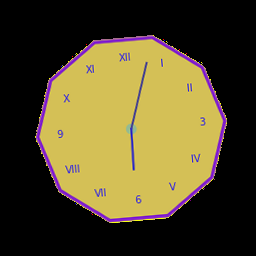

Model prediction: 01:00
Ground truth: 06:03


In [4]:
# Quick test: run the model on one random image from the dataset

sample = ds["val"][0] if "val" in ds else ds["test"][0]
img = sample["image"].convert("RGB")
display(img)

pred = qwen_predict_pil(img)
print("Model prediction:", pred)
print("Ground truth:", sample["text"])

In [5]:
from tqdm.auto import tqdm

SPLIT = "val" if "val" in ds else "test"
NUM = min(500, len(ds[SPLIT]))   # you can set 200 if it feels slow, or len(ds[SPLIT]) to do all

rows = []
for ex in tqdm(ds[SPLIT].select(range(NUM))):
    gold = ex["text"]               # ground truth "HH:MM"
    img  = ex["image"].convert("RGB")
    pred = qwen_predict_pil(img)    # model prediction "HH:MM" or None
    rows.append({"gold": gold, "pred": pred})

metrics = evaluate_predictions(rows)
save_report_csv_md("qwen2_vl_2b", rows, metrics)
metrics

  0%|          | 0/500 [00:00<?, ?it/s]

Saved: /content/outputs/qwen2_vl_2b_preds.csv and /content/outputs/qwen2_vl_2b_report.md


{'n_samples': 500,
 'predicted_any': 500,
 'exact_time_acc': 0.002,
 'hour_only_acc': 0.126,
 'minute_only_acc': 0.006}

In [6]:
import json, os

summary = {"qwen2_vl_2b_val": metrics}
with open("/content/outputs/summary.json", "w") as f:
    json.dump(summary, f, indent=2)

def md_row(name, m):
    return f"| {name} | {m['n_samples']} | {m['predicted_any']} | {m['exact_time_acc']:.3f} | {m['hour_only_acc']:.3f} | {m['minute_only_acc']:.3f} |"

lines = [
"# Qwen2-VL-2B results",
"",
"| Split | N | Predicted-any | Exact | Hour-only | Minute-only |",
"|---|---:|---:|---:|---:|---:|",
md_row("val/test", metrics)
]

with open("/content/outputs/summary.md", "w") as f:
    f.write("\n".join(lines))

print("Wrote /content/outputs/summary.md and /content/outputs/summary.json")


Wrote /content/outputs/summary.md and /content/outputs/summary.json


In [7]:
if "test_novel" in ds:
    from tqdm.auto import tqdm
    NUM = len(ds["test_novel"])          # do all novel samples
    rows_novel = []
    for ex in tqdm(ds["test_novel"].select(range(NUM))):
        gold = ex["text"]
        img  = ex["image"].convert("RGB")
        pred = qwen_predict_pil(img)
        rows_novel.append({"gold": gold, "pred": pred})
    metrics_novel = evaluate_predictions(rows_novel)
    save_report_csv_md("qwen2_vl_2b_novel", rows_novel, metrics_novel)

    # append to summary
    import json
    summary["qwen2_vl_2b_novel"] = metrics_novel
    with open("/content/outputs/summary.json", "w") as f:
        json.dump(summary, f, indent=2)
    with open("/content/outputs/summary.md", "a") as f:
        f.write("\n" + md_row("test_novel", metrics_novel))
    print("Updated summary.* files")
else:
    print("No 'test_novel' split detected.")


  0%|          | 0/1000 [00:00<?, ?it/s]

Saved: /content/outputs/qwen2_vl_2b_novel_preds.csv and /content/outputs/qwen2_vl_2b_novel_report.md
Updated summary.* files


In [1]:
# Install once (safe to re-run)
!pip -q install timm datasets pillow torchvision

import os, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms as T
import timm
from datasets import load_dataset
from PIL import Image
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# If you started a fresh notebook, reload the dataset:
try:
    ds
except NameError:
    ds = load_dataset("elischwartz/synthetic-watch-faces-dataset")
    print(ds)

os.makedirs("/content/outputs", exist_ok=True)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

data/val-00000-of-00001.parquet:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

data/test_novel-00000-of-00001.parquet:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test_novel split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 8000
    })
    val: Dataset({
        features: ['image', 'text'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 1000
    })
    test_novel: Dataset({
        features: ['image', 'text'],
        num_rows: 1000
    })
})


In [2]:
# Convert "HH:MM" string to integers; keep hours in 1..12, minutes in 0..59
def label_to_hm(label):
    hh, mm = map(int, label.split(":"))
    hh = ((hh - 1) % 12) + 1
    mm = mm % 60
    return hh, mm

# Stringify back to HH:MM (for reporting)
def hm_to_str(h, m):
    return f"{h:02d}:{m:02d}"

In [3]:
# Image transforms (resize + normalize like ImageNet)
size = 224
train_tf = T.Compose([
    T.Resize((size, size)),
    # light augmentation that doesn't break the time: small jitter/rotate
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    T.RandomRotation(degrees=5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_tf = T.Compose([
    T.Resize((size, size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def collate_from_split(split, batch_size, shuffle=False, transform=None):
    # We build batches directly from HF dataset to avoid loading all in RAM
    data = ds[split]
    n = len(data)
    idxs = list(range(n))

    def _gen():
        for i in idxs:
            ex = data[i]
            img = ex["image"].convert("RGB")
            if transform is not None:
                img = transform(img)
            hh, mm = label_to_hm(ex["text"])
            # convert hour to 0..11 for classification, minute 0..59
            yield img, (hh-1, mm)

    def _collate(batch):
        imgs = torch.stack([b[0] for b in batch])
        hours = torch.tensor([b[1][0] for b in batch], dtype=torch.long)
        minutes = torch.tensor([b[1][1] for b in batch], dtype=torch.long)
        return imgs, (hours, minutes)

    # Iterable-style dataset
    class _Wrap(torch.utils.data.IterableDataset):
        def __iter__(self): return _gen()

    loader = DataLoader(_Wrap(), batch_size=batch_size, shuffle=shuffle, collate_fn=_collate)
    return loader

train_loader = collate_from_split("train", batch_size=64, shuffle=True, transform=train_tf)
val_split = "val" if "val" in ds else "test"
val_loader   = collate_from_split(val_split, batch_size=128, shuffle=False, transform=eval_tf)

print("Loaders ready:", val_split)

ValueError: DataLoader with IterableDataset: expected unspecified shuffle option, but got shuffle=True

In [4]:
# --- Clean dataloaders that support shuffle properly ---

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

# Transforms (you can keep your previous size)
size = 224
train_tf = T.Compose([
    T.Resize((size, size)),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    T.RandomRotation(degrees=5),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
eval_tf = T.Compose([
    T.Resize((size, size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Map-style dataset (supports __len__/__getitem__)
class HFDataset(Dataset):
    def __init__(self, hf_split, transform=None):
        self.data = ds[hf_split]          # uses the HF dataset already loaded
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        img = ex["image"].convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        hh, mm = label_to_hm(ex["text"])  # -> (1..12, 0..59)
        return img, (hh-1, mm)            # hours -> 0..11 for classification

# Collate: stack tensors + build label tensors
def collate(batch):
    imgs = torch.stack([b[0] for b in batch])
    hours = torch.tensor([b[1][0] for b in batch], dtype=torch.long)
    minutes = torch.tensor([b[1][1] for b in batch], dtype=torch.long)
    return imgs, (hours, minutes)

val_split = "val" if "val" in ds else "test"
train_loader = DataLoader(HFDataset("train", transform=train_tf),
                          batch_size=64, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(HFDataset(val_split, transform=eval_tf),
                          batch_size=128, shuffle=False, collate_fn=collate)

# Quick sanity check: should print shapes like [64,3,224,224], [64], [64]
imgs,(h,m) = next(iter(train_loader))
print("batch imgs:", imgs.shape, "| hours:", h.shape, "| minutes:", m.shape)

batch imgs: torch.Size([64, 3, 224, 224]) | hours: torch.Size([64]) | minutes: torch.Size([64])


In [5]:
# Backbone as a frozen feature extractor
backbone = timm.create_model("resnet18", pretrained=True, num_classes=0)  # outputs features
for p in backbone.parameters():
    p.requires_grad = False

feat_dim = backbone.num_features
head_hour   = nn.Linear(feat_dim, 12)   # 12 classes (1..12) -> 0..11
head_minute = nn.Linear(feat_dim, 60)   # 60 classes (0..59)

backbone.to(device); head_hour.to(device); head_minute.to(device)

# Optimizer trains ONLY the small heads
optim = torch.optim.Adam(list(head_hour.parameters()) + list(head_minute.parameters()), lr=1e-3)
ce = nn.CrossEntropyLoss()

def forward_feats(x):
    return backbone(x)

def evaluate_loader(loader):
    n = 0; exact = 0; hour_ok = 0; minute_ok = 0
    head_hour.eval(); head_minute.eval(); backbone.eval()
    with torch.no_grad():
        for imgs, (h, m) in loader:
            imgs, h, m = imgs.to(device), h.to(device), m.to(device)
            feats = forward_feats(imgs)
            ph = head_hour(feats).argmax(1)     # 0..11
            pm = head_minute(feats).argmax(1)   # 0..59
            # back to human-readable ranges
            gh = h                               # 0..11
            gm = m
            exact   += ((ph==gh) & (pm==gm)).sum().item()
            hour_ok += (ph==gh).sum().item()
            minute_ok += (pm==gm).sum().item()
            n += h.size(0)
    return {
        "n_samples": n,
        "exact_time_acc": exact/n,
        "hour_only_acc": hour_ok/n,
        "minute_only_acc": minute_ok/n
    }

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [6]:
# Take one batch and do a forward pass
imgs, (h, m) = next(iter(train_loader))
imgs, h, m = imgs.to(device), h.to(device), m.to(device)

with torch.no_grad():
    feats = forward_feats(imgs)
    logits_h = head_hour(feats)
    logits_m = head_minute(feats)

print("feats:", feats.shape)           # e.g. [B, 512]
print("hour logits:", logits_h.shape)  # [B, 12]
print("minute logits:", logits_m.shape)# [B, 60]

# quick dummy loss just to confirm everything lines up
loss = ce(logits_h, h) + ce(logits_m, m)
print("dummy loss:", float(loss))

feats: torch.Size([64, 512])
hour logits: torch.Size([64, 12])
minute logits: torch.Size([64, 60])
dummy loss: 6.5701584815979


In [7]:
import os, json, random, datetime
from PIL import Image
import pandas as pd

# --- choose split for the gallery ---
if "test_novel" in ds:
    REF_SPLIT = "test_novel"
elif "test" in ds:
    REF_SPLIT = "test"
else:
    REF_SPLIT = "val"  # last resort

REF_DIR = "/content/outputs/reference_gallery"
RAW_DIR = os.path.join(REF_DIR, "raw")
os.makedirs(RAW_DIR, exist_ok=True)

# --- build hour buckets ---
hour_buckets = {h: [] for h in range(1, 13)}  # 1..12
for idx in range(len(ds[REF_SPLIT])):
    lab = ds[REF_SPLIT][idx]["text"]
    hh, mm = label_to_hm(lab)  # (1..12, 0..59)
    hour_buckets[hh].append(idx)

# --- sample balanced set (4 per hour -> 48 total). If not enough, sample what we can. ---
random.seed(1337)
PER_HOUR = 4
picked = []
for h in range(1, 13):
    pool = hour_buckets[h]
    if len(pool) == 0:
        continue
    k = min(PER_HOUR, len(pool))
    picked += random.sample(pool, k)

# fallback if too small
if len(picked) < 24:
    extras = [i for i in range(len(ds[REF_SPLIT])) if i not in picked]
    random.shuffle(extras)
    need = 24 - len(picked)
    picked += extras[:max(0, need)]

# --- save raw images and a CSV with gold labels ---
rows = []
for i in picked:
    ex = ds[REF_SPLIT][i]
    img = ex["image"].convert("RGB")
    hh, mm = label_to_hm(ex["text"])
    fname = f"{REF_SPLIT}_{i:06d}.jpg"
    img.save(os.path.join(RAW_DIR, fname), quality=95)
    rows.append({"split": REF_SPLIT, "idx": i, "file": fname, "gold": f"{hh:02d}:{mm:02d}"})

df = pd.DataFrame(rows)
df_path = os.path.join(REF_DIR, "gallery.csv")
df.to_csv(df_path, index=False)

meta = {
    "split": REF_SPLIT,
    "indices": [r["idx"] for r in rows],
    "seed": 1337,
    "created_utc": datetime.datetime.utcnow().isoformat() + "Z",
    "count": len(rows)
}
with open(os.path.join(REF_DIR, "gallery.json"), "w") as f:
    json.dump(meta, f, indent=2)

print(f"Reference Gallery: {len(rows)} images from split '{REF_SPLIT}'.")
print("Saved:", df_path, "and raw images under", RAW_DIR)

Reference Gallery: 48 images from split 'test_novel'.
Saved: /content/outputs/reference_gallery/gallery.csv and raw images under /content/outputs/reference_gallery/raw


/tmp/ipython-input-1267800742.py:60: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_utc": datetime.datetime.utcnow().isoformat() + "Z",


In [8]:
import torch, torch.nn as nn
from tqdm.auto import tqdm

epochs = 5  # increase later if you want

backbone.eval()                    # keep frozen backbone
head_hour.train(); head_minute.train()

optim = torch.optim.Adam(
    list(head_hour.parameters()) + list(head_minute.parameters()),
    lr=1e-3
)
ce = nn.CrossEntropyLoss()

for ep in range(1, epochs+1):
    running = 0.0; steps = 0
    for imgs, (h, m) in train_loader:
        imgs, h, m = imgs.to(device), h.to(device), m.to(device)
        feats = forward_feats(imgs)
        logits_h = head_hour(feats)
        logits_m = head_minute(feats)
        loss = ce(logits_h, h) + ce(logits_m, m)
        optim.zero_grad(); loss.backward(); optim.step()
        running += loss.item(); steps += 1

    val_metrics = evaluate_loader(val_loader)
    print(f"Epoch {ep}: loss={running/max(1,steps):.4f} | "
          f"val exact={val_metrics['exact_time_acc']:.3f} "
          f"hour={val_metrics['hour_only_acc']:.3f} "
          f"minute={val_metrics['minute_only_acc']:.3f}")

# save checkpoint (frozen stage)
torch.save({
    "head_hour": head_hour.state_dict(),
    "head_minute": head_minute.state_dict()
}, "/content/outputs/resnet18_heads_frozen.pt")

frozen_metrics = evaluate_loader(val_loader)
print("Frozen metrics:", frozen_metrics)

Epoch 1: loss=6.5528 | val exact=0.005 hour=0.143 minute=0.021
Epoch 2: loss=6.4229 | val exact=0.007 hour=0.154 minute=0.038
Epoch 3: loss=6.3255 | val exact=0.007 hour=0.185 minute=0.048
Epoch 4: loss=6.2374 | val exact=0.009 hour=0.190 minute=0.044
Epoch 5: loss=6.1595 | val exact=0.008 hour=0.198 minute=0.048
Frozen metrics: {'n_samples': 1000, 'exact_time_acc': 0.008, 'hour_only_acc': 0.198, 'minute_only_acc': 0.048}


In [9]:
# unfreeze only layer4
for name, p in backbone.named_parameters():
    if "layer4" in name:
        p.requires_grad = True

optim = torch.optim.Adam(
    list(filter(lambda p: p.requires_grad, backbone.parameters())) +
    list(head_hour.parameters()) + list(head_minute.parameters()),
    lr=5e-4
)

epochs_ft = 3
for ep in range(1, epochs_ft+1):
    backbone.train(); head_hour.train(); head_minute.train()
    running = 0.0; steps = 0
    for imgs, (h, m) in train_loader:
        imgs, h, m = imgs.to(device), h.to(device), m.to(device)
        feats = forward_feats(imgs)
        logits_h = head_hour(feats)
        logits_m = head_minute(feats)
        loss = ce(logits_h, h) + ce(logits_m, m)
        optim.zero_grad(); loss.backward(); optim.step()
        running += loss.item(); steps += 1

    val_metrics = evaluate_loader(val_loader)
    print(f"[FT] Epoch {ep}: loss={running/max(1,steps):.4f} | "
          f"val exact={val_metrics['exact_time_acc']:.3f} "
          f"hour={val_metrics['hour_only_acc']:.3f} "
          f"minute={val_metrics['minute_only_acc']:.3f}")

# save fine-tuned heads
torch.save({
    "head_hour": head_hour.state_dict(),
    "head_minute": head_minute.state_dict(),
    "ft_layer": "layer4"
}, "/content/outputs/resnet18_finetuned.pt")

ft_metrics = evaluate_loader(val_loader)
print("Fine-tuned metrics:", ft_metrics)

[FT] Epoch 1: loss=5.6788 | val exact=0.034 hour=0.420 minute=0.088
[FT] Epoch 2: loss=4.1707 | val exact=0.092 hour=0.632 minute=0.152
[FT] Epoch 3: loss=3.2523 | val exact=0.149 hour=0.776 minute=0.185
Fine-tuned metrics: {'n_samples': 1000, 'exact_time_acc': 0.149, 'hour_only_acc': 0.776, 'minute_only_acc': 0.185}


In [10]:
import os, json, pandas as pd
from torch.utils.data import DataLoader

# helper to stringify HH:MM
def hm_to_str(h, m): return f"{h:02d}:{m:02d}"

# predict a whole split and return rows
def predict_split(split_name, batch_size=128):
    loader = DataLoader(HFDataset(split_name, transform=eval_tf),
                        batch_size=batch_size, shuffle=False, collate_fn=collate)
    rows = []
    backbone.eval(); head_hour.eval(); head_minute.eval()
    with torch.no_grad():
        for imgs, (h, m) in loader:
            imgs = imgs.to(device)
            feats = forward_feats(imgs)
            ph = head_hour(feats).argmax(1).cpu().numpy()
            pm = head_minute(feats).argmax(1).cpu().numpy()
            h = h.numpy(); m = m.numpy()
            for gh, gm, prh, prm in zip(h, m, ph, pm):
                rows.append({"gold": hm_to_str(gh+1, gm),
                             "pred": hm_to_str(int(prh)+1, int(prm))})
    return rows

# evaluate rows -> metrics
def eval_rows(rows):
    n = len(rows); exact = hour_ok = minute_ok = 0
    for r in rows:
        gh, gm = map(int, r["gold"].split(":"))
        ph, pm = map(int, r["pred"].split(":"))
        if gh==ph and gm==pm: exact += 1
        if gh==ph: hour_ok += 1
        if gm==pm: minute_ok += 1
    return {
        "n_samples": n,
        "exact_time_acc": exact/n,
        "hour_only_acc": hour_ok/n,
        "minute_only_acc": minute_ok/n
    }

OUT = "/content/outputs"
os.makedirs(OUT, exist_ok=True)
summary = {}

# always do val/test if present
for split in ["val", "test", "test_novel"]:
    if split in ds:
        rows = predict_split(split)
        m = eval_rows(rows)
        summary[f"resnet18_{split}"] = m
        pd.DataFrame(rows).to_csv(os.path.join(OUT, f"resnet18_{split}_preds.csv"), index=False)
        with open(os.path.join(OUT, f"resnet18_{split}_report.md"), "w") as f:
            f.write(f"# ResNet18 on {split}\n")
            f.write(f"- N: {m['n_samples']}\n")
            f.write(f"- Exact: **{m['exact_time_acc']:.3f}**\n")
            f.write(f"- Hour:  **{m['hour_only_acc']:.3f}**\n")
            f.write(f"- Minute:**{m['minute_only_acc']:.3f}**\n")

# write summary files
with open(os.path.join(OUT, "resnet18_summary.json"), "w") as f:
    json.dump({"frozen": frozen_metrics, "finetuned_val": ft_metrics, **summary}, f, indent=2)

with open(os.path.join(OUT, "resnet18_summary.md"), "w") as f:
    f.write("# ResNet18 summary\n\n")
    f.write("## Validation (after fine-tune)\n")
    f.write(f"- exact: **{ft_metrics['exact_time_acc']:.3f}**, "
            f"hour: **{ft_metrics['hour_only_acc']:.3f}**, "
            f"minute: **{ft_metrics['minute_only_acc']:.3f}**\n\n")
    for k, m in summary.items():
        f.write(f"## {k}\n")
        f.write(f"- N: {m['n_samples']} | exact: **{m['exact_time_acc']:.3f}** | "
                f"hour: **{m['hour_only_acc']:.3f}** | minute: **{m['minute_only_acc']:.3f}**\n")

print("Reports written in /content/outputs/")

Reports written in /content/outputs/


In [11]:
import os, json, pandas as pd
from PIL import Image, ImageDraw, ImageFont

REF_DIR = "/content/outputs/reference_gallery"
RAW_DIR = os.path.join(REF_DIR, "raw")
ANN_DIR = os.path.join(REF_DIR, "annotated")
os.makedirs(ANN_DIR, exist_ok=True)

with open(os.path.join(REF_DIR, "gallery.json"), "r") as f:
    meta = json.load(f)
df = pd.read_csv(os.path.join(REF_DIR, "gallery.csv"))

def predict_pil(pil_img):
    x = eval_tf(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        feats = forward_feats(x)
        ph = head_hour(feats).argmax(1).item()   # 0..11
        pm = head_minute(feats).argmax(1).item() # 0..59
    return f"{ph+1:02d}:{pm:02d}"

def overlay(img, gold, pred, tag="ResNet18 (ft)"):
    im = img.convert("RGB").resize((256,256))
    draw = ImageDraw.Draw(im)
    font = ImageFont.load_default()
    # top bar
    draw.rectangle([0,0,256,28], fill=(0,0,0))
    exact = (pred == gold)
    color = (0,200,0) if exact else (220,60,60)
    text = f"{tag} | gold {gold} | pred {pred}"
    draw.text((4,6), text, font=font, fill=color)
    return im, exact

rows = []
for _, r in df.iterrows():
    path = os.path.join(RAW_DIR, r["file"])
    img = Image.open(path).convert("RGB")
    pred = predict_pil(img)
    im2, exact = overlay(img, r["gold"], pred)
    outname = r["file"].replace(".jpg", f"_{'ok' if exact else 'err'}.jpg")
    im2.save(os.path.join(ANN_DIR, outname), quality=92)
    rows.append({"file": r["file"], "gold": r["gold"], "pred": pred, "exact": exact})

pdf = pd.DataFrame(rows)
pdf.to_csv(os.path.join(REF_DIR, "annotated_results.csv"), index=False)

# zip for easy download
!zip -rq /content/outputs/reference_gallery_annotated.zip /content/outputs/reference_gallery
print("Saved annotated images to:", ANN_DIR)
print("ZIP:", "/content/outputs/reference_gallery_annotated.zip")

Saved annotated images to: /content/outputs/reference_gallery/annotated
ZIP: /content/outputs/reference_gallery_annotated.zip


In [12]:
!pip -q install opencv-python-headless

import cv2, math, numpy as np
from PIL import Image

# Rotate image by angle (degrees, + = counter-clockwise)
def _rotate_pil(pil_img, angle_deg):
    return pil_img.rotate(angle_deg, resample=Image.BILINEAR, expand=True, fillcolor=(0,0,0))

def align_watch(pil_img, debug=False):
    """
    Try to align the image so the *minute hand points to 12 o'clock* (vertical up).
    If detection fails, return the original image.
    """
    img = np.array(pil_img.convert("RGB"))
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    # Edges
    edges = cv2.Canny(gray, 60, 120)

    # Probabilistic Hough Lines
    lines = cv2.HoughLinesP(edges,
                            rho=1,
                            theta=np.pi/180,
                            threshold=60,
                            minLineLength=int(0.25*min(h,w)),
                            maxLineGap=10)
    if lines is None:
        return pil_img  # fallback

    cx, cy = w/2.0, h/2.0

    def score_line(L):
        x1,y1,x2,y2 = L[0]
        # length
        length = math.hypot(x2-x1, y2-y1)
        # distance of midpoint to center (prefer lines through center)
        mx, my = (x1+x2)/2.0, (y1+y2)/2.0
        d_center = math.hypot(mx-cx, my-cy) + 1e-6
        # prefer long & near center
        return length / d_center

    # Best candidate
    best = max(lines, key=score_line)[0]
    x1,y1,x2,y2 = best
    dy, dx = (y2-y1), (x2-x1)
    angle_rad = math.atan2(-dy, dx)  # y axis flipped in images
    angle_deg = math.degrees(angle_rad)

    # We want the minute hand vertical (pointing up = 90° w.r.t x-axis)
    # Current line angle vs x-axis is angle_deg; rotate by (90 - angle_deg)
    rotate_by = 90.0 - angle_deg
    aligned = _rotate_pil(pil_img, rotate_by)
    return aligned

In [13]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch

USE_ALIGN = True   # << turn off if you want to compare

size = 256
train_tf = T.Compose([
    T.Resize((size,size)),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
eval_tf = T.Compose([
    T.Resize((size,size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class HFDatasetAligned(Dataset):
    def __init__(self, hf_split, transform, use_align=False):
        self.data = ds[hf_split]
        self.transform = transform
        self.use_align = use_align
        self.split = hf_split
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        img = ex["image"].convert("RGB")
        if self.use_align:
            try:
                img = align_watch(img)
            except Exception:
                pass
        if self.transform:
            img = self.transform(img)
        hh, mm = label_to_hm(ex["text"])
        return img, (hh-1, mm)

def collate(batch):
    imgs = torch.stack([b[0] for b in batch])
    h = torch.tensor([b[1][0] for b in batch], dtype=torch.long)
    m = torch.tensor([b[1][1] for b in batch], dtype=torch.long)
    return imgs, (h,m)

val_split = "val" if "val" in ds else "test"

train_loader = DataLoader(HFDatasetAligned("train", transform=train_tf, use_align=USE_ALIGN),
                          batch_size=48, shuffle=True,  collate_fn=collate, num_workers=2)
val_loader   = DataLoader(HFDatasetAligned(val_split, transform=eval_tf, use_align=USE_ALIGN),
                          batch_size=96, shuffle=False, collate_fn=collate, num_workers=2)

imgs,(h,m)=next(iter(train_loader))
print("batch", imgs.shape, "| hours", h.shape, "| minutes", m.shape, "| aligned:", USE_ALIGN)

batch torch.Size([48, 3, 256, 256]) | hours torch.Size([48]) | minutes torch.Size([48]) | aligned: True


In [14]:
import torch.nn as nn
import torch

# Unfreeze layer3 + layer4
for name, p in backbone.named_parameters():
    if "layer3" in name or "layer4" in name:
        p.requires_grad = True

# Parameter groups: smaller LR for backbone, larger for heads
param_groups = [
    {"params": backbone.layer3.parameters(), "lr": 5e-5},
    {"params": backbone.layer4.parameters(), "lr": 5e-5},
    {"params": head_hour.parameters(),       "lr": 5e-4},
    {"params": head_minute.parameters(),     "lr": 5e-4},
]
optim = torch.optim.AdamW(param_groups, weight_decay=1e-4)

# Label smoothing helps a touch; minutes get higher weight
ce_h = nn.CrossEntropyLoss(label_smoothing=0.03)
ce_m = nn.CrossEntropyLoss(label_smoothing=0.03)
MINUTE_WEIGHT = 2.0

epochs_ft2 = 6
for ep in range(1, epochs_ft2+1):
    backbone.train(); head_hour.train(); head_minute.train()
    run = 0.0; steps = 0
    for imgs,(h,m) in train_loader:
        imgs,h,m = imgs.to(device), h.to(device), m.to(device)
        feats = forward_feats(imgs)
        logits_h = head_hour(feats)
        logits_m = head_minute(feats)
        loss = ce_h(logits_h, h) + MINUTE_WEIGHT * ce_m(logits_m, m)
        optim.zero_grad(); loss.backward(); optim.step()
        run += loss.item(); steps += 1

    val_metrics = evaluate_loader(val_loader)
    print(f"[FT2] Epoch {ep}: loss={run/max(1,steps):.4f} | "
          f"val exact={val_metrics['exact_time_acc']:.3f} "
          f"hour={val_metrics['hour_only_acc']:.3f} "
          f"minute={val_metrics['minute_only_acc']:.3f}")

# Save this stage
torch.save({
    "head_hour": head_hour.state_dict(),
    "head_minute": head_minute.state_dict(),
    "ft_layers": "layer3+layer4",
    "use_align": USE_ALIGN,
    "input_size": size
}, "/content/outputs/resnet18_finetuned_align256.pt")

ft2_metrics = evaluate_loader(val_loader)
ft2_metrics

[FT2] Epoch 1: loss=10.2924 | val exact=0.030 hour=0.229 minute=0.079
[FT2] Epoch 2: loss=9.3065 | val exact=0.036 hour=0.252 minute=0.105
[FT2] Epoch 3: loss=8.9042 | val exact=0.041 hour=0.265 minute=0.111
[FT2] Epoch 4: loss=8.5526 | val exact=0.043 hour=0.276 minute=0.116
[FT2] Epoch 5: loss=8.2234 | val exact=0.049 hour=0.302 minute=0.128
[FT2] Epoch 6: loss=7.9435 | val exact=0.067 hour=0.302 minute=0.154


{'n_samples': 1000,
 'exact_time_acc': 0.067,
 'hour_only_acc': 0.302,
 'minute_only_acc': 0.154}